In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyarrow.feather as feather
import io
from matplotlib.ticker import StrMethodFormatter
from datetime import datetime

%matplotlib inline


# Introduction

This is analysis of Lending Club Notes.  This notebook is mostly focused on the notes I own; aka **My LC Portfolio**.




a few things to keep in mind
- The state I reside in didn't allow auto-investing early-on.   
- Didn't have a strategy for every year  
- turned on auto-invest, picked a pre-canned blend  
- tweaked blend to heavy-skey of A's and B's to limit charged off  
- manual invest based on number of payments left  
- LendingClub changed they way they classified notes / evaluated risk  



This analysis is mostly exploratory. I have a few hunches and questions, I will see if I can find answers in the available data, and continue investigating depending on what I discover along the way.


 
***  

### Initial Observations about API Data 

`noteAmount`  on the API seems to be the "Order Amount", and not actually the orginal `noteAmount`.  This comes into play on the secondary market transactions, where you can buy a \$25.00 note, halfway of the way through the note's term, and pay, say, \$13.54  (assuming some premium or discount in this example) 

My expectations would be that  

`noteAmount`:  \$25.00  
`orderAmount`: \$13.54   


Similarly, due to secondary market discount / premium, the `orderAmount` is not actually the principal promised, or at least the fractional principal promised at time of ownership.
 
 

***  
#### Maybe for future iterations

It seems as though CSV downloads have different data fields so will explore those in part 2 of this analysis.

- [ ] analyize CSV

In [6]:
# The code was removed by Watson Studio for sharing.

In [7]:
# LendingClub Base API

lc_api_base_url = 'https://api.lendingclub.com/api'

### Helper Functions

In [8]:
def month_delta(_start_date, _end_date):
    if not _end_date:
        return 0
    num_months = (_end_date.year - _start_date.year) * 12 + (_end_date.month - _start_date.month)
    return num_months

In [8]:
def calculate_p_acquired(_row):
    # amount of principal promised to be repaid, acquired with purchase of note
    return _row['principalReceived'] + _row['principalPending']

def calc_prem_disc(_row):
    # difference between purchase amount of note and par value
    # REQUIRES PAR to be calculated first!!!
    
    return _row['order_amount'] - _row['p_acquired']

def calc_gain_loss_amount(_row):
    # calculate gross return amount
    # (gain recieved (aka interst) - losses - premium_discount) 
    # Requries previous values to be created
    #  ONLY VALID FOR COMPLETED LOANS ... if the loanStatus == Current ... pending principal will be treated as a loss, which it is not
    if _row['loanStatus'] in ['Charged Off', 'Fully Paid']:
        return _row['interestReceived'] - _row['principalPending'] - _row['premDiscAmount']
    else:
        return _row['interestReceived'] - _row['premDiscAmount']


def calc_roi(_row):
    # Calculate Return on Investment
    # REQUIRES above functiosn to ahve been run on DataFrame
    return _row['gainAmount'] / _row['order_amount']

def calc_expected_payment(_row):
    apr = _row['interestRate'] / 100
    i_r = apr / 12.
    p = _row['loanAmount']
    n = _row['loanLength']
    if _row['loanStatus'] in ['Charged Off', 'Fully Paid']:
        return 0.0
    else:    
        exp_pmnt = p * (i_r * (1 + i_r) ** n) / ((1 + i_r) ** n  - 1 )
        return exp_pmnt

def calc_expected_intested(_row):
    apr = _row['interestRate'] / 100
    i_r = apr / 12.
    
    if _row['loanStatus'] in ['Charged Off', 'Fully Paid']:
        return 0.
    else:
        return _row['principalPending'] * i_r

    
def pie_pct_format(pct, allvals, **kwargs):
    show_pct_only = False
    if 'p_only' in kwargs: 
        show_pct_only =  kwargs['p_only']
        
    absolute = int(pct/100.*np.sum(allvals))
    if pct  < 1: 
        return ""
    
    if show_pct_only:        
        return "{:.1f}%".format(pct)
    else:
        return "{:.1f}%\n({:d})".format(pct, absolute)        
    

    
    

In [10]:
# Call the LendingClub API to get owned notes
# Get Details on Owned Notes
_headers = {'Content-Type': 'application/json', 
            'Authorization': lc_api_token,
           'accept': 'application/json'}

acct_endpoint = lc_api_base_url + '/investor/{lc_api_version}/accounts/{lc_investor_id}/summary'.format(lc_api_version=lc_api_version, lc_investor_id=lc_investor_id)

notes_detail_endpoint = '{base_uri}/investor/{lc_api_version}/accounts/{investor_id}/detailednotes'.format(
    base_uri=lc_api_base_url, lc_api_version=lc_api_version, investor_id=lc_investor_id)

r = requests.get(notes_detail_endpoint, headers=_headers)

print(len(r.text))

965759


In [46]:
 # sanity test the data 
notes_data = r.json()
notes_data['myNotes'][0]

{'loanId': 561154,
 'noteId': 2256726,
 'orderId': 5323391,
 'portfolioId': 160202023,
 'purpose': 'Debt consolidation',
 'interestRate': 11.86,
 'loanLength': 60,
 'loanStatus': 'Fully Paid',
 'grade': 'B5',
 'currentPaymentStatus': 'Paid Off',
 'canBeTraded': True,
 'creditTrend': 'DOWN',
 'portfolioName': 'Completed',
 'loanAmount': 10000,
 'noteAmount': 61,
 'paymentsReceived': 85.23,
 'accruedInterest': 0,
 'principalPending': 0,
 'interestPending': 0,
 'principalReceived': 75.75,
 'interestReceived': 9.48,
 'nextPaymentDate': '2014-05-30T00:00:00.000-07:00',
 'issueDate': '2010-08-16T00:00:00.000-07:00',
 'orderDate': '2013-01-28T00:00:00.000-08:00',
 'loanStatusDate': '2014-04-30T00:00:00.000-07:00',
 'lastPaymentDate': '2014-04-30T11:31:25.000-07:00',
 'applicationType': 'INDIVIDUAL',
 'disbursementMethod': 'CASH'}

In [47]:
notes_df = pd.DataFrame.from_dict(notes_data['myNotes'])

# Data Clean-Up & Feature Engineering  

_NOTE_  Some of the functions to create new features, might be in the helper code section to keep code in a single area of the notebook.  




####  Concepts & Fields used 

- **Issue Date Vintage** `i_vintage`  The year of the loan issue date   
<br>

- **Order Date Vintage** `o_vintage`  The year of the order date, that is, when this note was added to my portfolio  
<br>  

- **Acquired Principal**  `p_acquired`  Amount of pricipal acquired with the purchase of this note. (i.e. conceptually outstanding principal on order date that I am purchasing )  
<br>  

- **Order Amount**  `order_amount`   Amount paid for this note  
<br>

- **Month Delta for Status**  `month_delta_for_status`  The number of months between **Issue Date** and the **Loan Status Date** (i.e. the date when when the loan status value changed.)  
<br>

- **Month Delta as Percentage**  `month_delta_as_pct`  What percent of the **Loan Term** is the **Month Delta for Status**.  Imagine a 36 month loan, and loan status changed at month 20, then the loan status perctage would be 55.6%  
<br>  

- **Month Delta for Last Pay**  `month_delta_for_last_pay`  The number of months between **Issue Date** and the **Last Payment Date**   
<br>  

- **Last Pay Date as Percentage**  `last_pay_as_pct`  What percent of the **Loan Term** is the **Month Delta for Last Pay**.  Imagine a 60 month loan, and the last payment happened on month 3;  the **Last Pay Date as Percentage** would be 5%  
<br>  

- **Adjusted Note Amount** `s_amt`  The note amount to include in summations.  When a note is charged off, you don't lose the entire note amount, but only the outstanding principal. The `s_amt` is a loan_status aware note amount, so that **Charged Off** notes, include the outstandign principal, but **Fully Paid** notes, will include note amount in the summation.   
<br>    


## Summary of work 

- convert date fields to be date types
- create `i_vintage` and `o_vintage`  
- calculate the premium or discount associated with this note order  
- calculate the gain / loss amount for this loan
- calculate the gross ROI for this note  
- calculate the loan level expected payment
- calculate the note level expected payment



In [48]:
# Data Massage, convert strings to datetime
# Also useful when loading from saved file

for c_name in ['loanStatusDate', 'nextPaymentDate', 'orderDate', 'issueDate', 'lastPaymentDate']:
    notes_df[c_name] = pd.to_datetime(notes_df[c_name])


In [49]:
# Create o_vintage ... based on Order date (i.e. when it was added to my portfolio), and not when the note was issued 

notes_df['o_vintage'] = notes_df['orderDate'].apply(lambda x: x.year)


In [50]:
# Create i_vintage ... based on Issue date i.e. when th note was issued by Lending Club

notes_df['i_vintage'] = notes_df['issueDate'].apply(lambda x: x.year)


In [51]:
# Calculate the number of months between loan issue date and loan status date
notes_df['month_delta_for_status'] = notes_df.apply(lambda row: month_delta(row['issueDate'], row['loanStatusDate']), axis=1)
notes_df['month_delta_for_last_pay'] = notes_df.apply(lambda row: month_delta(row['issueDate'], row['lastPaymentDate']), axis=1)

# Months detla a percentage of the loan lenth ... so a month delta of 30, and loan lenght of 60 = 50% ... or more precisely 0.5
notes_df['month_delta_as_pct'] = notes_df['month_delta_for_status'] / notes_df['loanLength']
notes_df['last_pay_as_pct'] = notes_df['month_delta_for_last_pay'] / notes_df['loanLength']



In [190]:
notes_df['order_amount'] = notes_df.apply(lambda r: r['noteAmount'], axis=1)   # API seems to store order amount in noteAmount field
notes_df['p_acquired'] = notes_df.apply(calculate_p_acquired, axis=1)
notes_df['premDiscAmount'] = notes_df.apply(calc_prem_disc, axis=1)
notes_df['gainAmount'] = notes_df.apply(calc_gain_loss_amount, axis=1)
notes_df['ROI'] = notes_df.apply(calc_roi, axis=1)
notes_df['loan_expected_payment'] = notes_df.apply(calc_expected_payment, axis=1)
notes_df['note_expected_payment'] = notes_df.apply(lambda r: r['loan_expected_payment'] * r['p_acquired'] / r['loanAmount'], axis=1)
notes_df['expectedInterestAmt'] = notes_df.apply(calc_expected_intested, axis=1)


In [131]:
# s_amt = sum amount, which is the amount I want to sum, to recreate the pie chart... for "Charged Off" status, I only want to
#   the amount actually lost
notes_df['s_amt'] = notes_df[['loanStatus', 'p_acquired', 'principalPending']].apply(lambda r :  r['principalPending'] if r['loanStatus'] == 'Charged Off' else r['p_acquired'], axis=1)




In [113]:
notes_df.head()

,accruedInterest,applicationType,canBeTraded,creditTrend,currentPaymentStatus,disbursementMethod,grade,interestPending,interestRate,interestReceived,...,month_delta_for_last_pay,month_delta_as_pct,last_pay_as_pct,parAmount,premDiscAmount,gainAmount,ROI,expectedPayments,expectedInterestAmt,s_amt
0,0.0,INDIVIDUAL,True,DOWN,Paid Off,CASH,B5,0.0,11.86,9.48,...,44,0.733333,0.733333,75.75,-14.75,24.23,0.397213,0.0,0.0,75.75
1,0.0,INDIVIDUAL,True,UP,Paid Off,CASH,D1,0.0,15.59,2.23,...,9,0.250000,0.250000,25.00,0.00,2.23,0.089200,0.0,0.0,25.00
2,0.0,INDIVIDUAL,True,DOWN,Paid Off,CASH,B5,0.0,11.86,0.99,...,49,0.833333,0.816667,11.02,0.04,0.95,0.085895,0.0,0.0,11.02
3,0.0,INDIVIDUAL,True,DOWN,Paid Off,CASH,C4,0.0,13.35,3.89,...,56,0.950000,0.933333,17.36,-0.26,4.15,0.242690,0.0,0.0,17.36
4,0.0,INDIVIDUAL,True,DOWN,Paid Off,CASH,B5,0.0,11.11,3.65,...,60,1.000000,1.000000,18.21,-1.83,5.48,0.334554,0.0,0.0,18.21


In [132]:
notes_df.shape

(1268, 43)

## Save a post-cleansed version of this DataFrame

In [133]:
# Safe as Arrow / Feather file  

buffer = io.BytesIO()
feather.write_feather( notes_df, buffer)

dataframe_storage_filename = datetime.utcnow().strftime('%Y_%I_%d') + '_lc_notes_dataframe.ftx'
print(dataframe_storage_filename)

buffer.seek(0)
project.save_data(dataframe_storage_filename, data=buffer, overwrite=True )


2020_04_06_lc_notes_dataframe.ftx


{'file_name': '2020_04_06_lc_notes_dataframe.ftx',
 'message': 'File saved to project storage.',
 'bucket_name': 'lendingclubanalysis-donotdelete-pr-rgsr1hhmibjkcl',
 'asset_id': '9325ee9a-3110-4eb1-b001-6f2938676184'}

## Load processed data from previous runs 

i.e. pickup where I left of

In [5]:
# Load from Arrow / Feather file
xxx = feather.read_feather(project.get_file("2020_04_06_lc_notes_dataframe.ftx"))
print(xxx.shape)
notes_df = xxx

(1268, 43)


/opt/conda/envs/Python36/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


# Exploratory Analysis
### Focusing on analysis to support post related to "Part 1"  


Let's start with basic composition of My Lending Club Portfolio

[posts on my website](https://tlm13.com)


In [28]:
vals = notes_df['loanStatus'].value_counts()
vals

Current               561
Fully Paid            524
Charged Off           163
Late (31-120 days)      9
In Grace Period         8
Late (16-30 days)       3
Name: loanStatus, dtype: int64

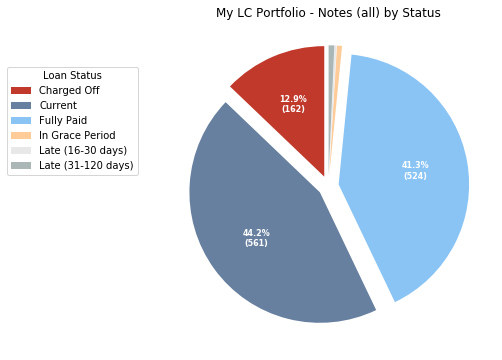

In [29]:

values = vals.sort_index()

colors = ['#c0392b','#67809f','#89c4f4', '#ffcc99' , '#e8e8e8', '#abb7b7']

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))


wedges, texts, autotexts = ax.pie(values, autopct=lambda pct: pie_pct_format(pct, values),
                                  textprops=dict(color="w"), explode=(0.08, 0.08, 0.08, 0.08, 0.08, 0.08),
                                 colors=colors, startangle=90)

ax.legend(wedges, sorted(values.index),
          title="Loan Status",
          loc="center left",
          bbox_to_anchor=(-0.5, 0, 0., 1.4))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("My LC Portfolio - Notes (all) by Status")

plt.show()

Now lets only look at the Complete Loans.  I.e. loanStatus in ["Fully Paid", "Charged Off"]

In [10]:
vals = notes_df[notes_df['loanStatus'].isin(['Fully Paid', 'Charged Off'])]['loanStatus'].value_counts()
vals

Fully Paid     524
Charged Off    163
Name: loanStatus, dtype: int64

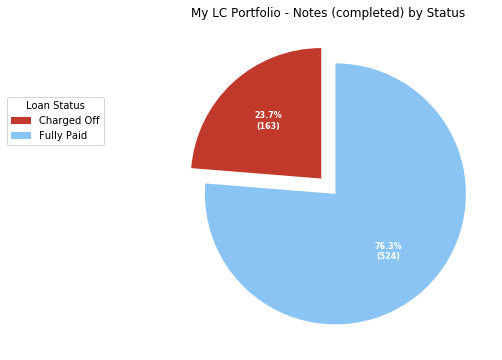

In [11]:
values = vals.sort_index()

#colors = ['#c0392b','#67809f','#89c4f4', '#ffcc99' , '#e8e8e8', '#abb7b7']
colors = ['#c0392b', '#89c4f4']

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))


wedges, texts, autotexts = ax.pie(values, autopct=lambda pct: pie_pct_format(pct, values),
                                  textprops=dict(color="w"), explode=(0.08, 0.08),
                                 colors=colors, startangle=90)

ax.legend(wedges, sorted(values.index),
          title="Loan Status",
          loc="center left",
          bbox_to_anchor=(-0.5, 0, 0., 1.4))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("My LC Portfolio - Notes (completed) by Status")

plt.show()

#### Rebuild Pie charts based on noteAmount (loan values) 

In [12]:
x = notes_df[['o_vintage', 'loanStatus',  
              'order_amount', 'p_acquired', 's_amt']].groupby(['loanStatus']).agg({'loanStatus': 'count', 
                                                                                   'order_amount': 'sum',
                                                                                   'p_acquired': 'sum',
                                                                                   's_amt': 'sum'})

print(x)



                    loanStatus  order_amount  p_acquired     s_amt
loanStatus                                                        
Charged Off                163       4081.86     4103.78   2816.32
Current                    561      12971.69    12952.46  12952.46
Fully Paid                 524      13273.60    13301.32  13301.32
In Grace Period              8        164.05      163.54    163.54
Late (16-30 days)            3         75.00       75.00     75.00
Late (31-120 days)           9        225.00      225.00    225.00


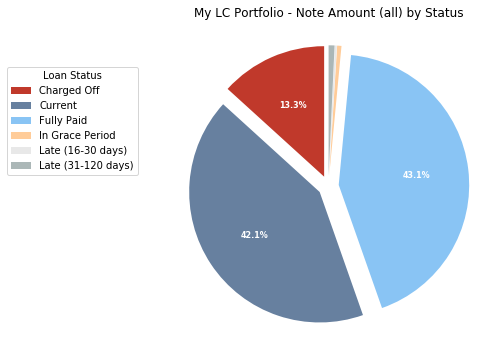

In [15]:
values = x['order_amount'].sort_index()

colors = ['#c0392b','#67809f','#89c4f4', '#ffcc99' , '#e8e8e8', '#abb7b7']

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))


wedges, texts, autotexts = ax.pie(values, autopct=lambda pct: pie_pct_format(pct, values, p_only=True),
                                  textprops=dict(color="w"), explode=(0.08, 0.08, 0.08, 0.08, 0.08, 0.08),
                                 colors=colors, startangle=90)

ax.legend(wedges, sorted(values.index),
          title="Loan Status",
          loc="center left",
          bbox_to_anchor=(-0.5, 0, 0., 1.4))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("My LC Portfolio - Note Amount (all) by Status")

plt.show()

####  My LC Portfolio amount by status for completed loans only 

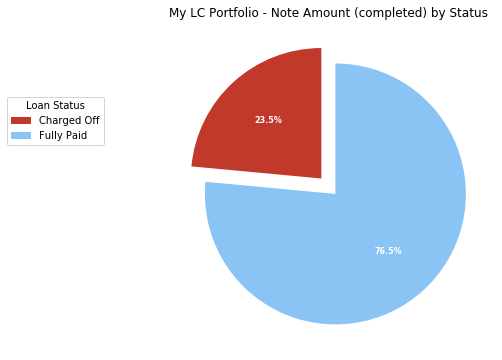

In [31]:
values = x[x.index.isin(['Charged Off', 'Fully Paid'])]['order_amount'].sort_index()

#colors = ['#c0392b','#67809f','#89c4f4', '#ffcc99' , '#e8e8e8', '#abb7b7']
colors = ['#c0392b', '#89c4f4']


fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))


wedges, texts, autotexts = ax.pie(values, autopct=lambda pct: pie_pct_format(pct, values, p_only=True),
                                  textprops=dict(color="w"), explode=(0.08, 0.08),
                                 colors=colors, startangle=90)

ax.legend(wedges, sorted(values.index),
          title="Loan Status",
          loc="center left",
          bbox_to_anchor=(-0.5, 0, 0., 1.4))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("My LC Portfolio - Note Amount (completed) by Status")

plt.show()

### Adjust Order Amount  ....

If a loan is charged off, the whole Order Amount is not lost, only the pending the principle 

... so use an adjust note amount to be included in the sum's  (I call this field the `s_amt`)

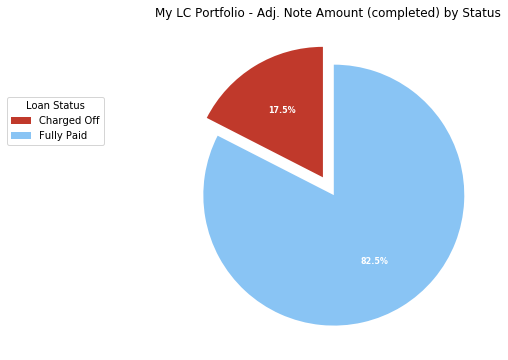

In [20]:
values = x[x.index.isin(['Charged Off', 'Fully Paid'])]['s_amt'].sort_index()

#colors = ['#c0392b','#67809f','#89c4f4', '#ffcc99' , '#e8e8e8', '#abb7b7']
colors = ['#c0392b', '#89c4f4']

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))


wedges, texts, autotexts = ax.pie(values, autopct=lambda pct: pie_pct_format(pct, values, p_only=True),
                                  textprops=dict(color="w"), explode=(0.08, 0.08),
                                 colors=colors, startangle=90)

ax.legend(wedges, sorted(values.index),
          title="Loan Status",
          loc="center left",
          bbox_to_anchor=(-0.5, 0, 0., 1.4))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("My LC Portfolio - Adj. Note Amount (completed) by Status")

plt.show()

In [34]:
l_amt_df = notes_df[['loanStatus', 's_amt']].groupby(['loanStatus']).agg('sum')

l_amt_df['s_amt']

loanStatus
Charged Off            2816.32
Current               12952.46
Fully Paid            13301.32
In Grace Period         163.54
Late (16-30 days)        75.00
Late (31-120 days)      225.00
Name: s_amt, dtype: float64

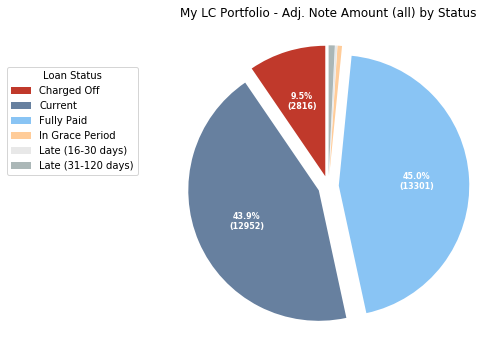

In [32]:
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))

colors = ['#c0392b','#67809f','#89c4f4', '#ffcc99' , '#e8e8e8', '#abb7b7']

wedges, texts, autotexts = ax.pie(l_amt_df['s_amt'], autopct=lambda pct: pie_pct_format(pct, l_amt_df['s_amt']),
                                  textprops=dict(color="w"), explode=(0.08, 0.08, 0.08, 0.08, 0.08, 0.08),
                                 colors=colors, startangle=90)

ax.legend(wedges, l_amt_df.index,
          title="Loan Status",
          loc="center left",
          bbox_to_anchor=(-0.5, 0, 0., 1.4))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("My LC Portfolio - Adj. Note Amount (all) by Status")

plt.show()

1


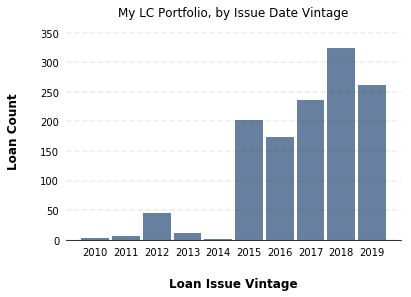

In [33]:
# Loans added to my portfolio by loan issue date 

ax = notes_df[['i_vintage']].hist(facecolor='#67809f', grid=False, rwidth=0.9, bins=np.arange(2010, 2021) - 0.5)
print (len(ax))
ax = ax[0]

for x in ax:
    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)
    x.set_xticks(np.arange(2010, 2020))

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom=False, top=False, labelbottom=True, left=False, right=False, labelleft=True)

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.1, color='#48413a', zorder=1)

    # Remove title
    x.set_title("My LC Portfolio, by Issue Date Vintage")

    # Set x-axis label
    x.set_xlabel("Loan Issue Vintage", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Loan Count", labelpad=20, weight='bold', size=12)

    # Format y-axis label
#    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
    x.set_facecolor('none')


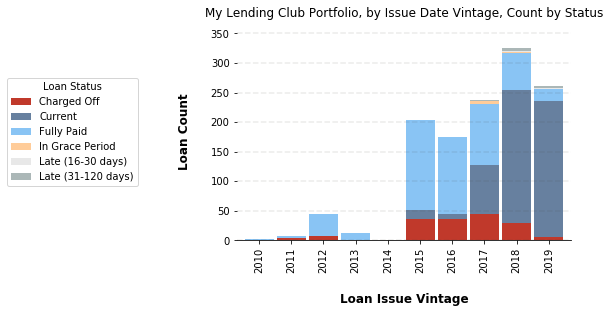

In [80]:
# COUNTS ... Build as Stacked Bar
colors = ['#c0392b','#67809f','#89c4f4', '#ffcc99' , '#e8e8e8', '#abb7b7']

ax = notes_df[['i_vintage', 'loanStatus' ]].groupby(['i_vintage'])['loanStatus'].value_counts().unstack(1).plot(kind="bar", stacked=True, grid=False, width=0.9, color=colors)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)


ax.legend(title="Loan Status",
          loc="center left",
          bbox_to_anchor=(-0.7, 0, 0., 1.0))

vals = ax.get_yticks()
for tick in vals:
    ax.axhline(y=tick, linestyle='dashed', alpha=0.1, color='#48413a', zorder=1)

# title
ax.set_title("My LC Portfolio, by Issue Date Vintage, Count by Status")

# Set x-axis label
ax.set_xlabel("Loan Issue Vintage", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Loan Count", labelpad=20, weight='bold', size=12)

# Format y-axis label
#    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
ax.set_facecolor('none')
 

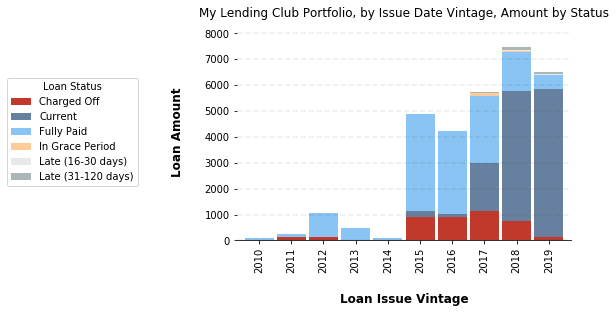

In [79]:
# VALUE ... Build as Stacked Bar
colors = ['#c0392b','#67809f','#89c4f4', '#ffcc99' , '#e8e8e8', '#abb7b7']

ax = notes_df[['i_vintage', 'loanStatus', 'noteAmount' ]].groupby(['i_vintage', 'loanStatus'])['noteAmount'].agg('sum').unstack(1).plot(kind="bar", stacked=True, grid=False, width=0.9, color=colors)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)


ax.legend(title="Loan Status",
          loc="center left",
          bbox_to_anchor=(-0.7, 0, 0., 1.0))

vals = ax.get_yticks()
for tick in vals:
    ax.axhline(y=tick, linestyle='dashed', alpha=0.1, color='#48413a', zorder=1)

# title
ax.set_title("My LC Portfolio, by Issue Date Vintage, Amount by Status")

# Set x-axis label
ax.set_xlabel("Loan Issue Vintage", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Loan Amount", labelpad=20, weight='bold', size=12)

# Format y-axis label
#    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
ax.set_facecolor('none')
 

## Order Date Vintage Analysis

In [59]:
# Lets look at teh Order Date Vintage Couns
y = notes_df[['o_vintage', 'loanStatus']].groupby(['o_vintage']).agg(['count'])['loanStatus']
print(y)

           count
o_vintage       
2012          20
2013          35
2014          63
2015         141
2016         165
2017         224
2018         267
2019         300
2020          53


1


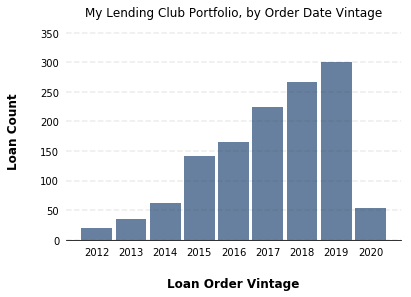

In [70]:
# Loans added to my portfolio by loan order date 

ax = notes_df[['o_vintage']].hist(facecolor='#67809f', grid=False, rwidth=0.9, bins=np.arange(2012, 2022) - 0.5)
print (len(ax))
ax = ax[0]
for x in ax:
    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)
    x.set_xticks(np.arange(2012, 2021))

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom=False, top=False, labelbottom=True, left=False, right=False, labelleft=True)

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.1, color='#48413a', zorder=1)

    # Remove title
    x.set_title("My LC Portfolio, by Order Date Vintage")

    # Set x-axis label
    x.set_xlabel("Loan Order Vintage", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Loan Count", labelpad=20, weight='bold', size=12)

    # Format y-axis label
#    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
    x.set_facecolor('none')


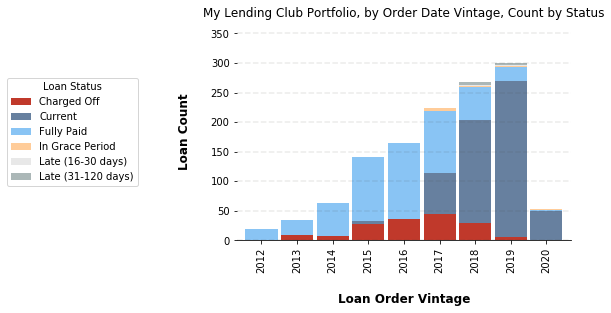

In [87]:
# Build as Stacked Bar
colors = ['#c0392b','#67809f','#89c4f4', '#ffcc99' , '#e8e8e8', '#abb7b7']

ax = notes_df[['o_vintage', 'loanStatus' ]].groupby(['o_vintage'])['loanStatus'].value_counts().unstack(1).plot(kind="bar", stacked=True, grid=False, width=0.9, color=colors)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)


ax.legend(title="Loan Status",
          loc="center left",
          bbox_to_anchor=(-0.7, 0, 0., 1.0))

vals = ax.get_yticks()
for tick in vals:
    ax.axhline(y=tick, linestyle='dashed', alpha=0.1, color='#48413a', zorder=1)

# title
ax.set_title("My LC Portfolio, by Order Date Vintage, Count by Status")

# Set x-axis label
ax.set_xlabel("Loan Order Vintage", labelpad=20, weight='bold', size=12)

# Set y-axis label
ax.set_ylabel("Loan Count", labelpad=20, weight='bold', size=12)

# Format y-axis label
#    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))
ax.set_facecolor('none')
    


In [38]:
notes_df[notes_df['loanStatus'].isin(['Fully Paid', 'Charged Off'])][['i_vintage', 'loanStatus']].groupby(['i_vintage']).agg(['count'])




,loanStatus
,count
i_vintage,
2010,3
2011,7
2012,45
2013,12
2014,1
2015,187
2016,165
2017,149


***  
***  


# Scratch Pad Analysis ...

Working ahead on what might be included in "Part 2" post related to Lending CLub Analysis 

Most of the analysis below is a work in progress, research, testing, etc


#### Suggest you stop reading here .. 


##  Accordign LendingClub Stats page

If you look at all notes maybe screen shot this 
[foo](https://www.lendingclub.com/info/demand-and-credit-profile.action) 


Total Issued =     $42,537,651,475
Total Charged off = $3,361,716,614

Charge Off Amount is 7.90% of total loan issued.

My personal portfolio charge off is 9.14%


Not horrible, if we assume higher charge off is due to extra risk, were there additional returns ?

Total P  recieved = $27,577,695,011 
Total I  recieved =  $6,821,806,059

In [45]:
print('Charge Off Rate  {:.2%}'.format(3361716614 / 42537651475))
print('(P + I)/ Total Issued = payback / invested  {:.2%}'.format((27577695011 + 6821806059)/42537651475))
print('P outstanding {:.2%}'.format((42537651475 - 3361716614 - 27577695011)/42537651475))
print('P Charge off / P received {:.2%}'.format(3361716614/27577695011))

Charge Off Rate  7.90%
(P + I)/ Total Issued = payback / invested  80.87%
P outstanding 27.27%
P Charge off / P received 12.19%


In [152]:
# my portfolio  
#  The calculation in the Pie chart does not handle the received principal prior to charge off.
# The result is that charge off as a percentatge is overstated

t_invested = np.sum(notes_df['order_amount'])
p_received = np.sum(notes_df['principalReceived'])
p_charged_off = np.sum(notes_df[notes_df['loanStatus'] == 'Charged Off']['principalPending'])
i_received = np.sum(notes_df['interestReceived'])
total_gain = np.sum(notes_df['gainAmount'])

print('Charge Off Rate  {:.2%}'.format( p_charged_off / t_invested))

print('(P + I)/ Total Issued = payback / invested  {:.2%}'.format((p_received + i_received) / t_invested))
print('P outstanding {:.2%}'.format((t_invested - p_charged_off - p_received) / t_invested))
print('P Charge off / P received {:.2%}'.format(p_charged_off / p_received))
print('gross ROI {:.2%}'.format(total_gain / t_invested))


Charge Off Rate  9.15%
(P + I)/ Total Issued = payback / invested  75.30%
P outstanding 28.01%
P Charge off / P received 14.55%
gross ROI 3.40%


In [146]:
notes_df[['loanStatus', 'loanAmount', 'order_amount', 'p_acquired', 'principalPending', 'principalReceived']].groupby(['loanStatus']).agg('sum')

,loanAmount,order_amount,p_acquired,principalPending,principalReceived
loanStatus,,,,,
Charged Off,3957625,4081.86,4103.78,2816.32,1287.46
Current,12869200,12971.69,12952.46,8374.89,4577.57
Fully Paid,12342950,13273.60,13301.32,0.00,13301.32
In Grace Period,193100,164.05,163.54,60.21,103.33
Late (16-30 days),110000,75.00,75.00,57.97,17.03
Late (31-120 days),231125,225.00,225.00,160.46,64.54


In [47]:
x = notes_df[['o_vintage', 'loanStatus',  
              'order_amount', 'p_acquired', 's_amt', 'gainAmount']].groupby(['loanStatus']).agg({'loanStatus': 'count', 
                                                                                   'order_amount': 'sum',
                                                                                   'p_acquired': 'sum',
                                                                                   's_amt': 'sum',
                                                                                    'gainAmount': 'sum'})

print(x)



                    loanStatus  order_amount  p_acquired     s_amt  gainAmount
loanStatus                                                                    
Charged Off                163       4081.86     4103.78   2816.32    -2303.72
Current                    561      12971.69    12952.46  12952.46     1488.86
Fully Paid                 524      13273.60    13301.32  13301.32     1796.95
In Grace Period              8        164.05      163.54    163.54       27.68
Late (16-30 days)            3         75.00       75.00     75.00        7.81
Late (31-120 days)           9        225.00      225.00    225.00       29.77


In [48]:
x = notes_df[['o_vintage', 'loanStatus',  
              'order_amount', 'p_acquired', 's_amt', 'gainAmount']].groupby(['o_vintage']).agg({'loanStatus': 'count', 
                                                                                   'order_amount': 'sum',
                                                                                   'p_acquired': 'sum',
                                                                                   's_amt': 'sum',
                                                                                    'gainAmount': 'sum'})

print(x)



           loanStatus  order_amount  p_acquired    s_amt  gainAmount
o_vintage                                                           
2012               20        551.98      525.95   525.95       60.28
2013               35        866.53      940.32   869.71      -19.71
2014               63       1776.30     1778.88  1694.48      123.08
2015              141       3525.00     3525.00  3225.70      161.61
2016              165       4125.00     4125.00  3806.78      -13.79
2017              224       5600.00     5600.00  5246.75       15.33
2018              267       6675.00     6675.00  6520.75      289.18
2019              300       6956.96     6948.60  6941.17      433.40
2020               53        714.43      702.35   702.35       -2.03


In [186]:
x = calc_expected_payment(notes_df.iloc[1055]) 
x

897.884335283294

In [24]:
notes_df.iloc[1055]['lastPaymentDate'] - notes_df.iloc[1055]['issueDate'] 

datetime.timedelta(314, 35870)

In [188]:
notes_df.iloc[1055]['p_acquired'] / notes_df.iloc[1055]['loanAmount'] * calc_expected_payment(notes_df.iloc[1055]) 

0.5611777095520588

notes_df.iloc[1055] 

In [181]:
notes_df[notes_df['i_vintage'] == 2011][['loanStatus','noteAmount', 'order_amount', 'interestReceived', 'principalReceived', 'principalPending', 's_amt', 'gainAmount']]

,loanStatus,noteAmount,order_amount,interestReceived,principalReceived,principalPending,s_amt,gainAmount
4,Fully Paid,16.38,16.38,3.65,18.21,0.00,18.21,5.48
5,Charged Off,19.00,19.00,0.00,0.00,20.70,20.70,-19.00
6,Fully Paid,47.50,47.50,7.61,55.81,0.00,55.81,15.92
7,Charged Off,11.50,11.50,0.10,0.71,10.73,10.73,-10.69
8,Fully Paid,33.50,33.50,8.02,38.01,0.00,38.01,12.53
9,Charged Off,13.99,13.99,0.00,0.00,18.21,18.21,-13.99
10,Charged Off,99.00,99.00,2.40,7.88,95.32,95.32,-88.72


In [36]:
# Count Pivot
count_pivot_df = notes_df[['o_vintage', 'loanStatus', 'noteAmount']].pivot_table(index='o_vintage', columns='loanStatus', values='noteAmount', aggfunc=len, fill_value=0, margins=True)
count_pivot_df


loanStatus,Charged Off,Current,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days),All
o_vintage,,,,,,,
2012,1,0,19,0,0,0,20.0
2013,10,0,25,0,0,0,35.0
2014,8,0,55,0,0,0,63.0
2015,28,4,109,0,0,0,141.0
2016,37,0,128,0,0,0,165.0
2017,44,70,105,4,0,1,224.0
2018,30,173,57,1,1,5,267.0
2019,5,265,23,2,2,3,300.0
2020,0,49,3,1,0,0,53.0


In [132]:
# Note Amount SUM Pivot
amt_pivot_df = notes_df[['my_vintage', 'loanStatus', 'noteAmount', 'principalPending', 'parAmount', 'interestReceived', 'expectedPayments', 'portfolioName']].pivot_table(index='portfolioName', columns='loanStatus', values='expectedPayments', aggfunc=sum, fill_value=0, margins=True)
amt_pivot_df



loanStatus,Charged Off,Current,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days),All
portfolioName,,,,,,,
"Active, Open Loans",0,366.928428,0,4.156273,3.494511,7.922157,382.501369
"Active, Trading Platform",0,27.886901,0,0.384396,0.000000,0.000000,28.271297
Completed,0,0.000000,0,0.000000,0.000000,0.000000,0.000000
All,0,394.815328,0,4.540669,3.494511,7.922157,410.772666


In [41]:
grouped_notes = notes_df[notes_df['loanStatus'].isin(['Fully Paid', 'Charged Off'])].groupby(['o_vintage'])[['noteAmount', 'paymentsReceived', 'principalReceived', 
                                                                                              'interestReceived', 'principalPending', 'parAmount', 'premDiscAmount',
                                                                                              'gainAmount',
                                                                                              'month_delta_as_pct']].agg('sum')

grouped_notes

,noteAmount,paymentsReceived,principalReceived,interestReceived,principalPending,parAmount,premDiscAmount,gainAmount,month_delta_as_pct
o_vintage,,,,,,,,,
2012,551.98,612.26,505.25,107.01,20.70,525.95,26.03,60.28,12.616667
2013,866.53,847.00,727.85,118.97,212.47,940.32,-73.79,-19.71,26.233333
2014,1776.30,1899.36,1663.28,236.10,115.60,1778.88,-2.58,123.08,44.355556
2015,3425.00,3550.34,3024.30,525.74,400.70,3425.00,0.00,125.04,100.616667
2016,4125.00,4112.00,3518.22,592.99,606.78,4125.00,0.00,-13.79,116.150000
2017,3725.00,3426.37,2978.25,446.97,746.75,3725.00,0.00,-299.78,73.333333
2018,2175.00,1776.28,1579.25,196.68,595.75,2175.00,0.00,-399.07,25.388889
2019,675.09,592.33,557.29,34.99,117.57,674.86,0.23,-82.81,5.238889
2020,35.56,35.55,35.09,0.46,0.00,35.09,0.47,-0.01,1.861111


In [43]:
#grouped_notes['vintageROI'] = grouped_notes.apply(calc_roi, axis=1)
#grouped_notes

In [40]:
grouped_all_notes = notes_df.groupby(['o_vintage'])[['noteAmount', 'paymentsReceived', 'principalReceived', 
                                                                                              'interestReceived', 'principalPending', 'parAmount', 'premDiscAmount',
                                                                                              'gainAmount', 'expectedPayments',
                                                                                              'month_delta_as_pct', 'interestPending', 'accruedInterest']].agg('sum')
grouped_all_notes['vintageROI'] = grouped_notes.apply(calc_roi, axis=1)

grouped_all_notes

NameError: name 'grouped_notes' is not defined

In [96]:
notes_df.groupby(['loanStatus'])[['principalPending', 'month_delta_as_pct', 'noteAmount']].agg(['min', 'mean', 'sum'])

principalPending                     month_delta_as_pct  \
                                min       mean      sum                min   
loanStatus                                                                   
Charged Off                    0.44  17.278037  2816.32           0.116667   
Current                        0.00  15.175072  8467.69           0.000000   
Fully Paid                     0.00   0.000000     0.00           0.000000   
In Grace Period                0.00  13.650000   150.15           0.166667   
Late (16-30 days)              1.71   9.162000    45.81           0.150000   
Late (31-120 days)             8.52  17.828889   160.46           0.150000   

                                         noteAmount                       
                        mean         sum        min       mean       sum  
loanStatus                                                                
Charged Off         0.494785   80.650000      11.50  25.042086   4081.86  
Current             0.143459   80.050000       5.62  23.102151  12891.00  
Fully Paid          0.619989  322.394444       6.07  25.385846  13200.64  
In Grace Period     0.526768    5.794444      11.96  22.831818    251.15  
Late (16-30 days)   0.724444    3.622222      25.00  25.000000    125.00  
Late (31-120 days)  0.402469    3.622222      25.00  25.000000    225.00

In [16]:
notes_df[['loanStatusDate', 'nextPaymentDate', 'orderDate', 'issueDate', 'portfolioName', 'loanStatus', 'loanLength', 'lastPaymentDate', 'month_delta_as_pct', 'last_pay_as_pct']][:4]

,loanStatusDate,nextPaymentDate,orderDate,issueDate,portfolioName,loanStatus,loanLength,lastPaymentDate,month_delta_as_pct,last_pay_as_pct
0,2014-04-30 00:00:00-07:00,2014-05-30 00:00:00-07:00,2013-01-28 00:00:00-08:00,2010-08-16 00:00:00-07:00,Completed,Fully Paid,60,2014-04-30 11:31:25-07:00,0.733333,0.733333
1,2015-10-20 00:00:00-07:00,2015-11-06 00:00:00-08:00,2014-12-18 00:00:00-08:00,2015-01-02 00:00:00-08:00,Completed,Fully Paid,36,2015-10-07 11:26:08-07:00,0.250000,0.250000
2,2014-12-19 00:00:00-08:00,2014-12-26 00:00:00-08:00,2014-01-08 00:00:00-08:00,2010-10-19 00:00:00-07:00,Completed,Fully Paid,60,2014-11-26 10:38:01-08:00,0.833333,0.816667
3,2015-09-14 00:00:00-07:00,2015-09-23 00:00:00-07:00,2012-11-28 00:00:00-08:00,2010-12-17 00:00:00-08:00,Completed,Fully Paid,60,2015-08-20 12:01:22-07:00,0.950000,0.933333


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1eb97314a8>,
      dtype=object)

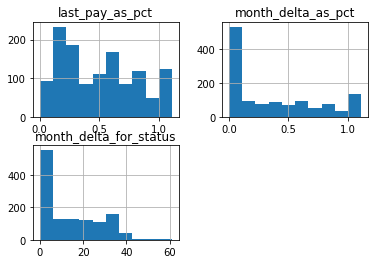

In [17]:
notes_df[['month_delta_for_status', 'month_delta_as_pct', 'last_pay_as_pct']].hist()

In [217]:
notes_df[['month_delta_for_status', 'month_delta_as_pct', 'last_pay_as_pct']].describe()

,month_delta_for_status,month_delta_as_pct,last_pay_as_pct
count,1255.000000,1255.000000,1255.000000
mean,13.880478,0.360177,0.495086
std,13.770449,0.359478,0.302976
min,0.000000,0.000000,0.000000
25%,1.000000,0.027778,0.222222
50%,10.000000,0.250000,0.472222
75%,25.000000,0.666667,0.750000
max,61.000000,1.111111,1.111111


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f041426f518>,
      dtype=object)

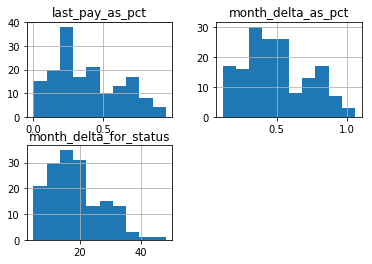

In [218]:
notes_df[notes_df['loanStatus'] == 'Charged Off'][['month_delta_for_status', 'month_delta_as_pct', 'last_pay_as_pct']].hist()

In [219]:
notes_df[notes_df['loanStatus'] == 'Charged Off'][['month_delta_for_status', 'month_delta_as_pct', 'last_pay_as_pct']].describe()

,month_delta_for_status,month_delta_as_pct,last_pay_as_pct
count,163.000000,163.000000,163.000000
mean,18.693252,0.494785,0.381493
std,8.644795,0.225156,0.231169
min,5.000000,0.116667,0.000000
25%,12.000000,0.333333,0.194444
50%,17.000000,0.444444,0.333333
75%,25.000000,0.658333,0.583333
max,48.000000,1.055556,0.944444


In [100]:
notes_df[(notes_df['month_delta_for_status'] > 0) & (notes_df['loanStatus'] == 'Charged Off')][['issueDate', 'loanStatusDate', 
                                                                                            'month_delta_for_status', 'loanStatus',  
                                                                                            'accruedInterest', 'currentPaymentStatus', 
                                                                                            'interestReceived', 'paymentsReceived', 'principalPending',
                                                                                            'portfolioName', 'noteId', 'loanLength', 
                                                                                             'nextPaymentDate', 'lastPaymentDate', 'month_delta_as_pct']]

,issueDate,loanStatusDate,month_delta_for_status,loanStatus,accruedInterest,currentPaymentStatus,interestReceived,paymentsReceived,principalPending,portfolioName,noteId,loanLength,nextPaymentDate,lastPaymentDate,month_delta_as_pct
5,2011-05-18 00:00:00-07:00,2013-01-31 00:00:00-08:00,20,Charged Off,0.0,ChargedOff,0.00,0.00,20.70,Completed,4704146,60,2013-01-25 00:00:00-08:00,2012-08-24 14:15:29-07:00,0.333333
7,2011-07-21 00:00:00-07:00,2013-10-31 00:00:00-07:00,27,Charged Off,0.0,ChargedOff,0.10,0.81,10.73,Completed,5547804,36,2013-10-28 00:00:00-07:00,2013-06-12 13:14:04-07:00,0.750000
9,2011-11-07 00:00:00-08:00,2013-12-31 00:00:00-08:00,25,Charged Off,0.0,ChargedOff,0.00,0.00,18.21,Completed,7051931,60,2013-12-12 00:00:00-08:00,2013-08-14 11:36:26-07:00,0.416667
10,2011-11-10 00:00:00-08:00,2013-07-31 00:00:00-07:00,20,Charged Off,0.0,ChargedOff,2.40,10.28,95.32,Completed,7095598,36,2013-07-25 00:00:00-07:00,2013-03-05 13:31:37-08:00,0.555556
12,2012-01-17 00:00:00-08:00,2014-10-31 00:00:00-07:00,33,Charged Off,0.0,ChargedOff,1.21,11.72,6.15,Completed,8117966,36,2014-11-28 00:00:00-08:00,2014-07-11 11:32:28-07:00,0.916667
18,2012-03-16 00:00:00-07:00,2014-12-18 00:00:00-08:00,33,Charged Off,0.0,ChargedOff,4.57,31.05,12.56,Completed,9213508,36,2015-01-23 00:00:00-08:00,2014-07-28 10:22:52-07:00,0.916667
19,2012-04-09 00:00:00-07:00,2014-02-28 00:00:00-08:00,22,Charged Off,0.0,ChargedOff,1.98,7.73,14.61,Completed,9798565,36,2014-02-21 00:00:00-08:00,2013-10-11 10:42:00-07:00,0.611111
24,2012-04-03 00:00:00-07:00,2014-03-31 00:00:00-07:00,23,Charged Off,0.0,ChargedOff,2.58,8.93,14.17,Completed,9695114,36,2014-03-20 00:00:00-07:00,2013-11-18 12:10:05-08:00,0.638889
28,2012-05-16 00:00:00-07:00,2013-08-21 00:00:00-07:00,15,Charged Off,0.0,ChargedOff,0.00,0.00,19.31,Completed,10756551,36,2013-07-26 00:00:00-07:00,2013-02-28 14:10:17-08:00,0.416667
30,2012-05-29 00:00:00-07:00,2014-09-22 00:00:00-07:00,28,Charged Off,0.0,ChargedOff,1.98,9.44,10.95,Completed,10964803,36,2014-09-05 00:00:00-07:00,2014-05-07 11:35:21-07:00,0.777778


In [160]:
fails = notes_df[notes_df['loanStatus'] == 'Charged Off']['month_delta_as_pct']
f_bins = pd.cut(fails, bins=[0, 0.25, 0.5, 0.75, 1.])


In [161]:
ax = f_bins.value_counts().plot.bar

In [173]:
f_bins.value_counts()

(0.25, 0.5]    70
(0.5, 0.75]    41
(0.75, 1.0]    26
(0.0, 0.25]    25
Name: month_delta_as_pct, dtype: int64

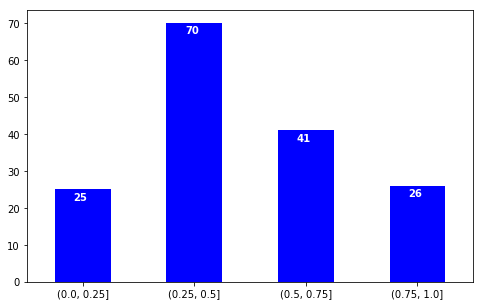

In [210]:
# Create Bins for what percentage of total term the charge-off happened.  
ax = f_bins.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(8,5))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + (p.get_width()/2. - .08), p.get_height() - 2.9), color="w", weight="bold")
plt.show()

In [223]:
# Repeat teh analsyis with last payment % for charged off ... it takes a months for last payment to turn into a charge off ... so using 50% of payments less, might be a better filter
last_pay_fails = notes_df[notes_df['loanStatus'] == 'Charged Off']['last_pay_as_pct']
lp_bins = pd.cut(last_pay_fails, bins=[0, 0.25, 0.5, 0.75, 1.])
lp_bins.value_counts()



(0.25, 0.5]    60
(0.0, 0.25]    56
(0.5, 0.75]    33
(0.75, 1.0]    12
Name: last_pay_as_pct, dtype: int64

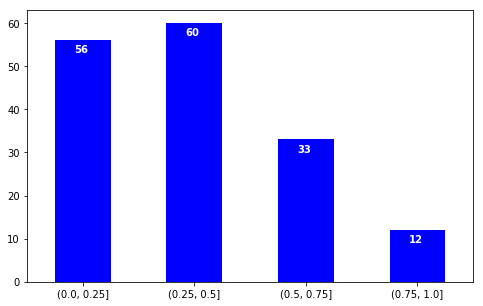

In [224]:
# Create Bins for what percentage of total term the last-payment happened.  
ax = lp_bins.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(8,5))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + (p.get_width()/2. - .08), p.get_height() - 2.9), color="w", weight="bold")
plt.show()

In [131]:
notes_df[(notes_df['loanStatus'] == 'Charged Off') & (notes_df['month_delta_as_pct'] > 0.5)][['month_delta_for_status', 'month_delta_as_pct']].describe()

,month_delta_for_status,month_delta_as_pct
count,68.000000,68.000000
mean,26.852941,0.718791
std,6.208479,0.137038
min,19.000000,0.527778
25%,21.000000,0.583333
50%,26.000000,0.722222
75%,31.000000,0.812500
max,48.000000,1.055556
